## SAM 能力验证

导入相关的包

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

data_model_dir = '/home/scc/Downloads/AIToy/P3_Segment_Anything/1.sam_demo'

In [13]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## 测试图片

In [8]:
image = cv2.imread(f'{data_model_dir}/images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [9]:
image.shape

(1200, 1800, 3)

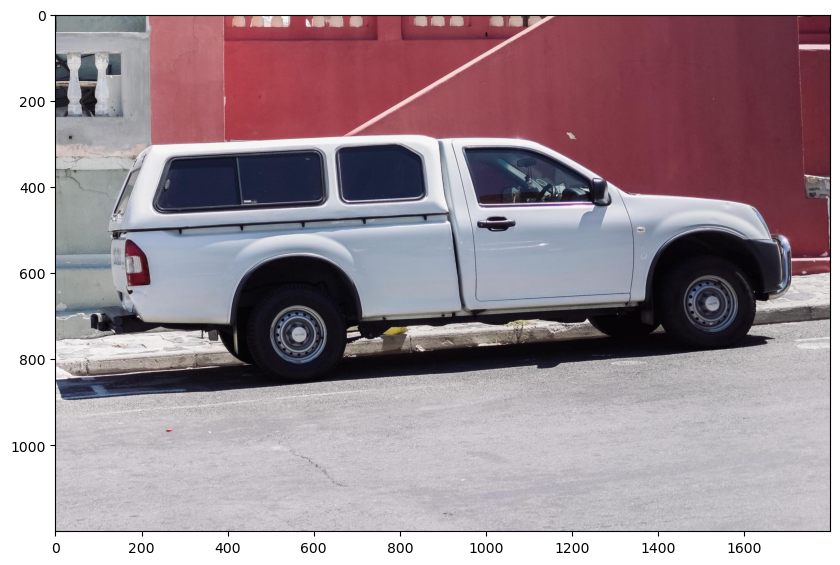

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## 使用SAM分割

In [11]:
from segment_anything import sam_model_registry, SamPredictor
# 模型权重文件
sam_checkpoint = f"{data_model_dir}/sam_vit_h_4b8939.pth"
# 模型类型
model_type = "vit_h" # largest
# 使用GPU
device = "cuda"
# 加载模型
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# 将模型放到GPU上
sam.to(device=device)
# 创建预测器
predictor = SamPredictor(sam)

In [12]:
# 使用`SamPredictor.set_image`生成embedding。 `SamPredictor`将记住这个值，并将其用于后续的掩膜预测。
predictor.set_image(image)

In [14]:
# 选择一个点 (x, y) 作为输入
input_point = np.array([[500, 375]])
# 标注这个点的类别，
# 1 表示foreground，即前景点， need 
# 0 表示background，即背景点  not need
input_label = np.array([1])

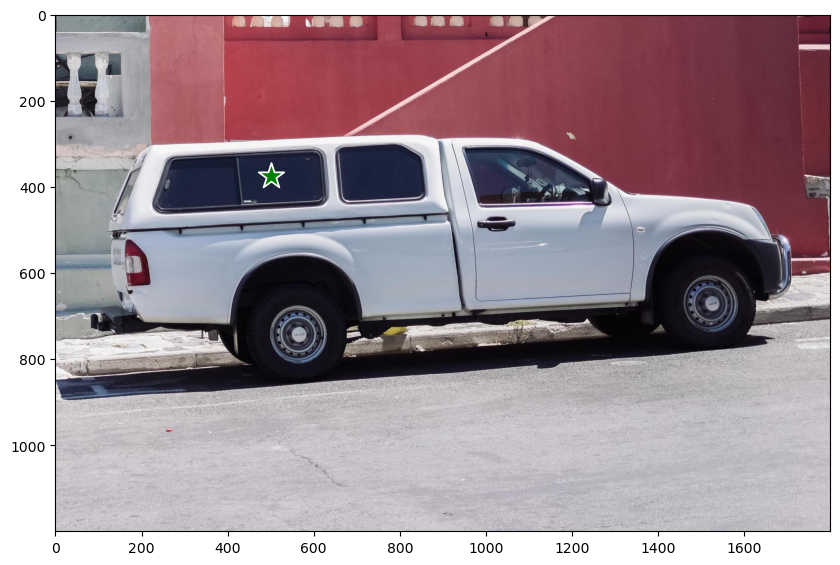

In [15]:
# 绘制检查一下
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [16]:
# 使用预训练模型进行预测，参数：点坐标，点标签，是否输出多分支mask，输出：多分支mask，分数，logits
# 当multimask_output=True时，输出3个分支的mask，为False时，输出1个分支的mask。未解决prompt提示模糊问题，建议使用True，然后通过scores进行筛选
masks, scores, logits = predictor.predict(
    point_coords=input_point, # 点坐标
    point_labels=input_label, # 点标签
    multimask_output=True, # 是否输出多分支mask 输出：多分支mask，分数，logits
)

In [17]:
#  (number_of_masks) x H x W
masks.shape

(3, 1200, 1800)

In [ ]:
# masks[0]

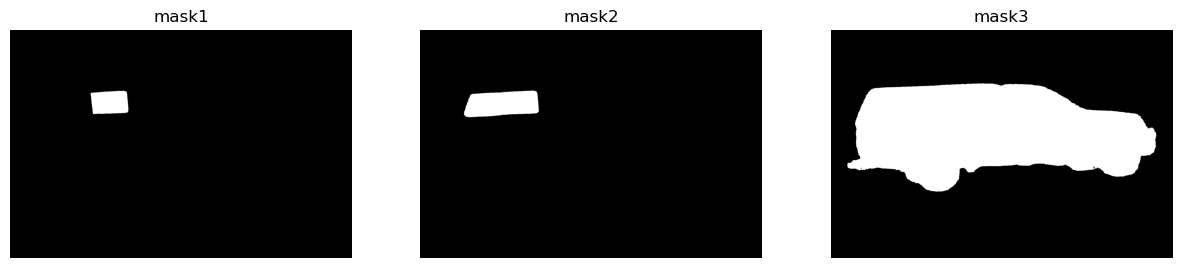

In [18]:
# 分别显示三个mask
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(masks[i], cmap='gray')
    plt.axis('off')
    plt.title('mask'+str(i+1))
plt.show()

In [19]:
# 三个mask的预测分数
scores

array([0.993738 , 1.0023912, 0.9776994], dtype=float32)

In [20]:
# logit是没有经过softmax之前的值
logits.shape 

(3, 256, 256)

In [21]:
logits

array([[[-18.852482 , -22.529491 , -20.710754 , ..., -25.732138 ,
         -22.278946 , -25.746944 ],
        [-20.236519 , -26.923607 , -20.983837 , ..., -25.762362 ,
         -23.812944 , -25.206253 ],
        [-19.582314 , -22.858418 , -20.513443 , ..., -24.0779   ,
         -21.500624 , -24.562529 ],
        ...,
        [-28.145914 , -41.075478 , -31.771503 , ..., -31.22092  ,
         -27.331747 , -28.626818 ],
        [-36.010403 , -34.37113  , -43.101818 , ..., -26.73307  ,
         -29.426025 , -26.31788  ],
        [-27.948978 , -40.742847 , -31.211388 , ..., -29.31482  ,
         -26.530758 , -26.635778 ]],

       [[-18.854534 , -20.32378  , -19.549911 , ..., -18.828981 ,
         -19.367334 , -19.588089 ],
        [-17.254602 , -22.955482 , -17.569479 , ..., -20.603085 ,
         -18.732637 , -20.050646 ],
        [-17.679035 , -19.59162  , -18.495975 , ..., -18.219608 ,
         -19.158255 , -18.862183 ],
        ...,
        [-25.760826 , -33.89261  , -27.450241 , ..., -

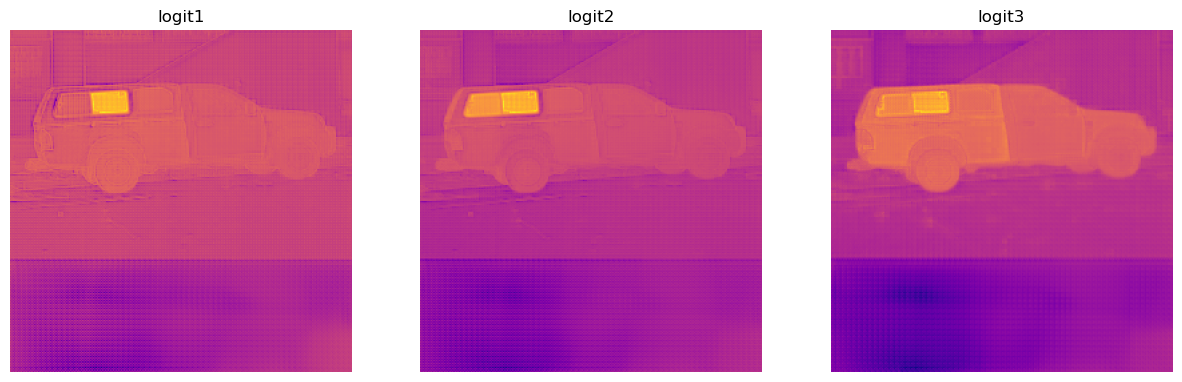

In [22]:
# 分别显示三个logits，logits表示每个像素点属于哪个类别的概率，logits越大，表示该像素点属于该类别的概率越大
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(logits[i], cmap='plasma') # plasma表示热力图，越小越紫，越大越黄
    plt.axis('off')
    plt.title('logit'+str(i+1))
plt.show()

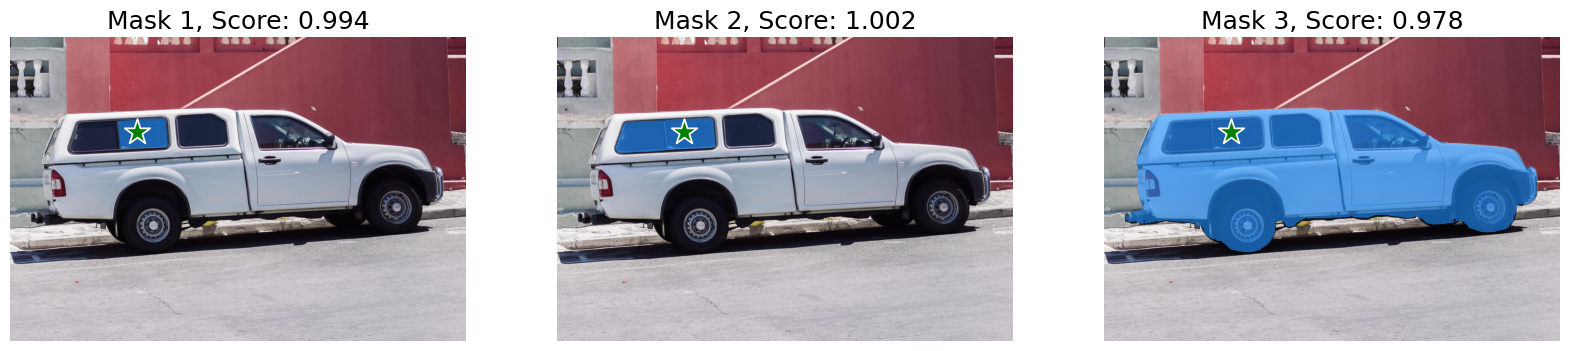

In [23]:
# 将结果绘制在图像上
plt.figure(figsize=(20,10))
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
plt.show()

  

In [24]:
img_copy = image.copy()
# 使用图片数组的方式贴图
seg = masks[0]
# 若mask为true，则将img_copy中的像素置为半透明
alpha = 0.7
color = (255,0,255)
# 意思是所有mask为true的地方 一半像素来自于原始像素，另一半来自于 color
img_copy[seg > 0,0] = img_copy[seg > 0,0] * alpha + color[0] * (1-alpha) #b
img_copy[seg > 0,1] = img_copy[seg > 0,1] * alpha + color[1] * (1-alpha) #g
img_copy[seg > 0,2] = img_copy[seg > 0,2] * alpha + color[2] * (1-alpha) #r

(-0.5, 1799.5, 1199.5, -0.5)

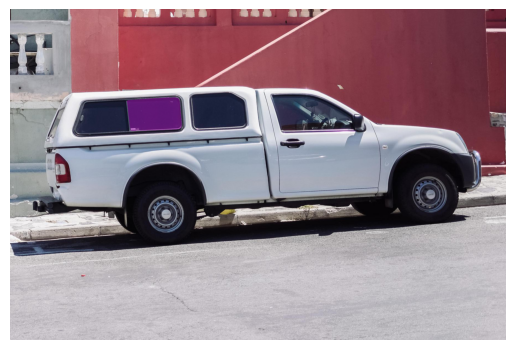

In [25]:
# 显示
plt.imshow(img_copy)
plt.axis('off')

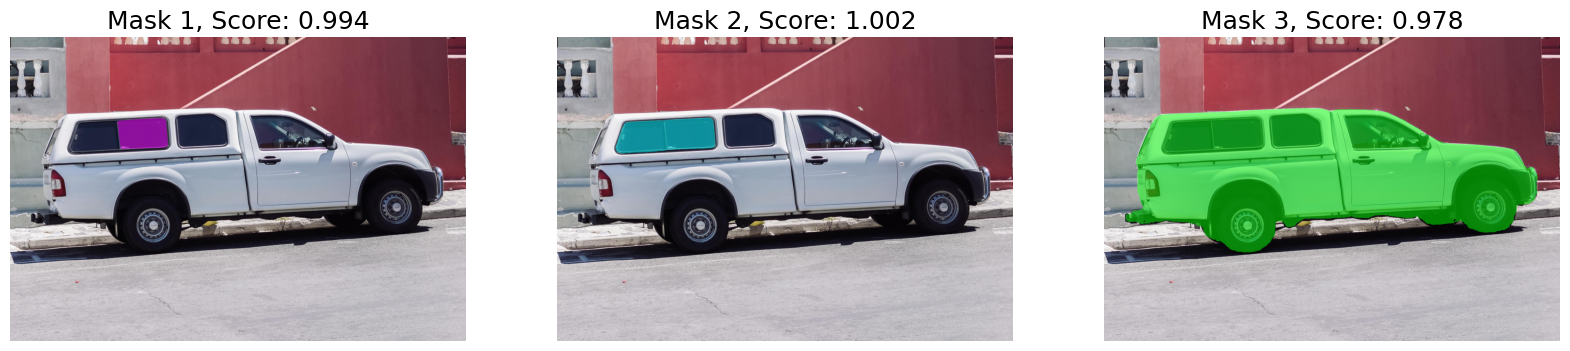

In [26]:
plt.figure(figsize=(20,10))
alpha = 0.5
colors  = [(255,0,255), (0,255,255), (0,255,0)]
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.subplot(1,3,i+1)
    img_copy = image.copy()
    # 使用图片数据的方式贴图
    seg = masks[i]
    # 若mask为true，则将img_copy中的像素置为半透明
    color =colors[i]
    img_copy[seg > 0,0] = img_copy[seg > 0,0] * alpha + color[0] * (1-alpha)
    img_copy[seg > 0,1] = img_copy[seg > 0,1] * alpha + color[1] * (1-alpha)
    img_copy[seg > 0,2] = img_copy[seg > 0,2] * alpha + color[2] * (1-alpha)

    plt.imshow(img_copy)
    
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
plt.show()

## 使用更多点确定目标

In [27]:
# 输入的2个点坐标
input_point = np.array([[500, 375], [1125, 625]])
# 都是1，表示都是正样本
input_label = np.array([1, 1])

In [28]:
# If available, a mask from a previous iteration can also be supplied to the model to aid in prediction.
# 如果可用，还可以向模型提供来自上一次迭代的掩码以帮助预测。

mask_input = logits[np.argmax(scores), :, :]  # 选择最大分值的那个类别的logits

In [29]:
# 使用预训练模型进行预测，参数：点坐标，点标签，输入mask，是否输出多个mask（在多点确定一个物体时，可以将此值设为False）

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [30]:
masks.shape

(1, 1200, 1800)

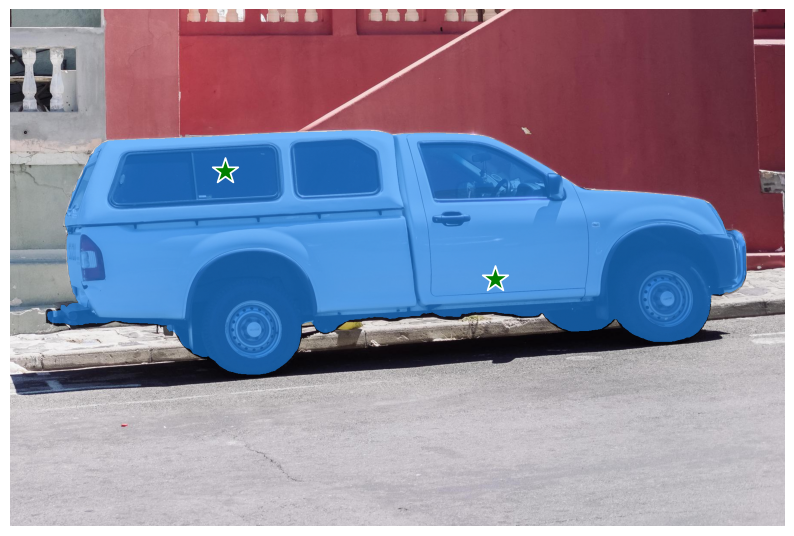

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

In [32]:
# 如果只想要玻璃而不要车身，可以将第二个点的label改为0
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [33]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

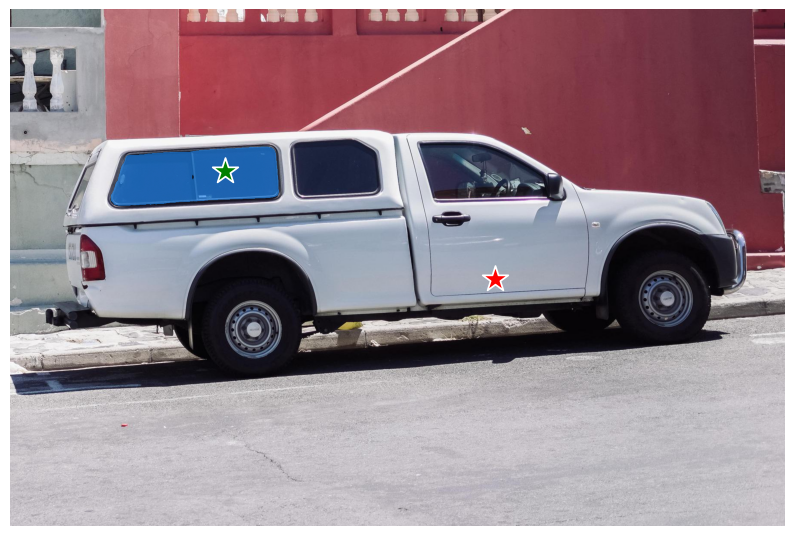

In [34]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

## 使用矩形框作为提示

In [35]:
# 矩形框坐标：l, t, r, b
input_box = np.array([425, 600, 700, 875])

In [36]:
# box：shape (n, 4) 
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :], 
    multimask_output=False,
)

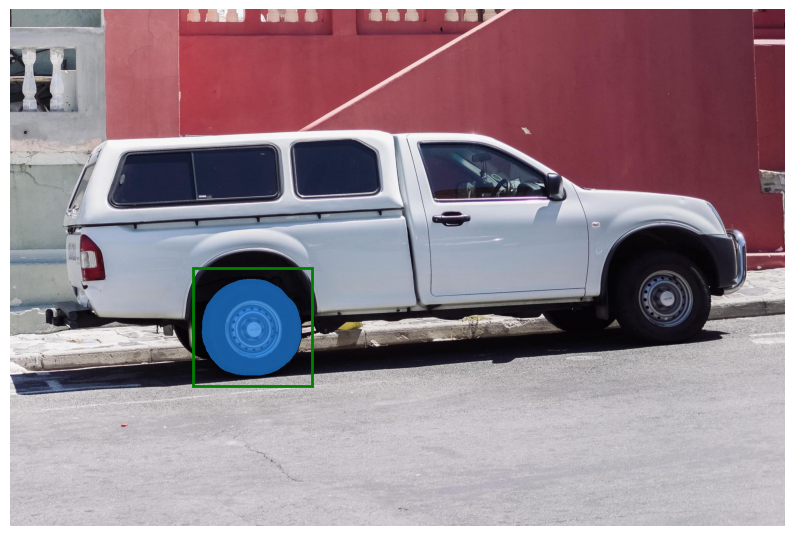

In [37]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## 点与矩形框结合提示

In [38]:
# 这里使用电鱼矩形框结合，只选择车轮胎（将车轮胎中心点的label设为0，移除选区）
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [39]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

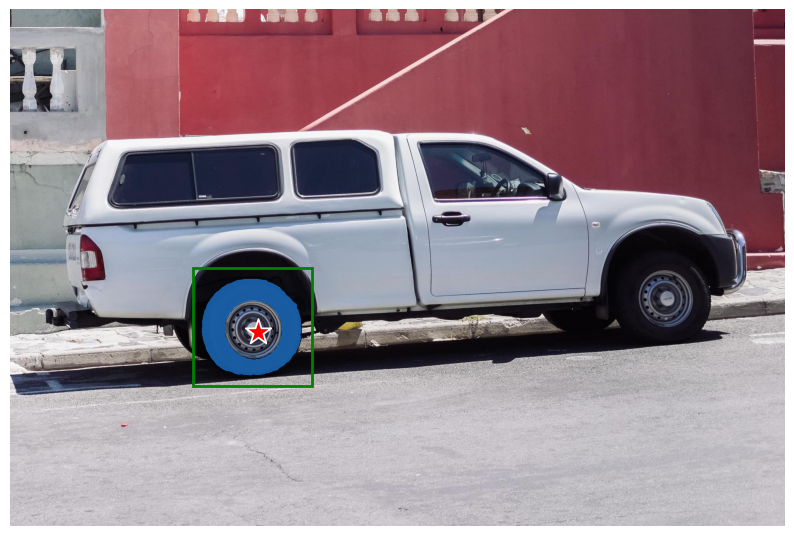

In [40]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()